In [1]:
import shelve
import re
import os
from predict_price_helpers import *

In [2]:
with shelve.open('./predict-price.shelve', flag='r') as slf:
    for k,v in slf.items():
        print(k)
        globals()[k] = v
        if re.match('def\d+:', k) is not None:
            print(v)
            exec(v)

RESULTS_DIR
def0:
do_save = lambda fn: not(os.path.isfile(fn))
cfg
num_columns
cat_columns
models
df


In [3]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

In [4]:
# set figure defaults (needs to be in cell seperate from import sns)
plt.style.use([
    'default',
    f"{cfg['FILE_LOCATION']['app_dir']}/assets/movshon.mplstyle",
    f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-notebook.mplstyle"
])

# Model: Multiple linear fit

Above [simple linear models](#pred_model_1) only use _Age_ as predictor of price. Here MLR will regress many (numerical) features with price (euro).  


## Prepare input

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model

model_name = 'MLR reduced observations'

features = num_columns 
# Can be reduced here

X = df.dropna(subset=['price'] + features).loc[:,features].values.reshape(-1,len(features))
y = np.log10(df.dropna(subset=['price'] + features).price.values.reshape(-1,1))
print(X.shape)
print(y.shape)

(2614, 20)
(2614, 1)


## Fit

In [6]:
# instantiate a dict in models at key with name of this model
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X_train,y_train)
models[model_name].update({'n':y.shape[0]})
models[model_name].update({'n features':X.shape[1]})

# parameters
betas = [*reg.intercept_, *reg.coef_[0]]
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})
models[model_name].update({'test R^2':reg.score(X_test,y_test)})
cv_results = cross_val_score(reg, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})


(1829, 20)
(785, 20)


/home/tom/bin/satdatsci/Saturday-Datascience/results/MLR_reduced_observations.png


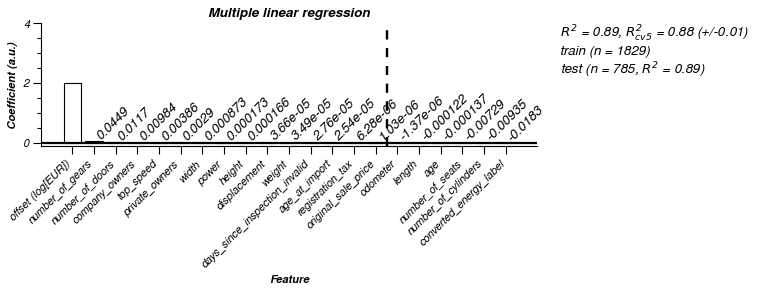

In [7]:
# plot coefficients
plt.figure(figsize=[8,2])
ax=plt.gca()

# sorted bar height
betas = models[model_name]['betas']
x = ['offset (log[EUR])'] + [features[i] for i in np.argsort(betas[1:])[::-1]]
y = [betas[0]] + sorted(betas[1:], reverse=True)

# plot bar
ax.bar(x=x, height=y, edgecolor='k', facecolor='None')

# add values when bar is small
for x_val, coef in zip(x,y):
    if np.abs(coef)<1:
        ax.text(x_val, coef, '{:.3g}'.format(coef), rotation=45, va='bottom', ha='left')
ax.set_yticks(range(0,5,2))

# plot origin
x_sign_switch = np.nonzero(np.array(y) < 0)[0][0]
ax.axvline(x_sign_switch-0.5, linewidth=2, linestyle='--', color='k')
ax.axhline(0, linewidth=2, linestyle='-', color='k')
        
x_sign_switch = np.nonzero(np.array(y) < 0)[0][0]
yl = ax.get_ylim()
ax.vlines(x_sign_switch-0.5, yl[0], yl[1], linewidth=2, linestyle='--')
ax.set_ylim(yl)
# ax.set_ylim(top=0.01, bottom=-0.01)

# labels
ax.set_xticks(x)
ax.set_xticklabels(labels=x, rotation=45, va='top', ha='right', style='italic')
ax.xaxis.set_tick_params(which='minor', bottom=False)
ax.set_xlabel('Feature', style='italic')
ax.set_ylabel('Coefficient (a.u.)', style='italic')
ax.set_title('Multiple linear regression', style='italic') 

# stats
xy=[ax.get_xlim()[1], ax.get_ylim()[1]]
ax.text(xy[0]*1.05,xy[1], '$R^2$ = {:.2f}, $R^2_{{cv{:g}}}$ = {:.2f} (+/-{:.2f})'.format(
    models[model_name]['R^2'],
    models[model_name]['cv R^2'].shape[0],
    np.mean(models[model_name]['cv R^2']),
    np.std(models[model_name]['cv R^2']),
) + '\n' +
         'train (n = {})'.format(y_train.shape[0]) + '\n' +
         'test (n = {}, $R^2$ = {:.2f})'.format(
             y_test.shape[0],
             models[model_name]['test R^2'],
         ), style='italic', va='top', ha='left')


# Save
file_name = f"{RESULTS_DIR}/{model_name.replace(' ','_')}.png"
if True | do_save(file_name): # always save
    print(file_name)
    with plt.style.context(f"{cfg['FILE_LOCATION']['app_dir']}/assets/context-paper.mplstyle"):
        plt.savefig(file_name, bbox_inches='tight', transparent=False)
else:
    plt.show()
    print(f'Skip. {file_name} exists or saving is disabled in settings.')

In [8]:
fn = './predict-price.shelve'
with shelve.open(fn, flag='w') as slf:
    slf['models'] = models 
    print(f'Shelve file [{fn}] contains models:')
    for m in slf['models'].keys():
        print(f'\t{m}')

Shelve file [./predict-price.shelve] contains models:
	linear regression no cv
	linear regression log price young
	MLR reduced observations
